# Table of Contents

[Introduction](#1)

[Section 1: Preparing the Data](#2)

[Section 2: Examining the Balance of Classes](#3)

[Section 3: Improving the Quality of the Model](#4)
- [APPROACH #1 (Upsampling)](#4.1)
- [APPROACH #2 (Downsampling)](#4.2)

[Section 4: Performing the Final Test](#5)

[Conclusion](#6)

# Introduction <a id=1></a>

I am a data scientist for Beta Bank who has been hired to build a machine learning model that uses data on clients’ past behavior and termination of contracts with the bank to predict whether or not a customer is likely to leave the bank soon. 

It is imperative that the model has an F1 score of at least 0.59, largely because Beta Bank stakeholders have realized that it is cheaper to keep existing customers than it is to attract new ones. 

To help me build the (random forest) model, I follow the steps below:

1) Download the behavior dataset and prepare it.

2) Examine the balance of classes by first training the model without taking into account any imbalances.

3) Improve the quality of the model by using two different approaches (upsampling and downsampling) to fix the class imbalance. 

4) Perform a final test on the model, and compare the AUC-ROC metric to the F1 value.

# Section 1: Preparing the Data <a id=2></a>

The features and target of the dataframe on clients' past behavior are the following:

**FEATURES**
* RowNumber — Index of the data string
* CustomerId — The unique identifier of the customer
* Surname — The surname of the customer
* CreditScore — The credit score of the customer
* Geography — The customer's country of residence
* Gender — The customer's gender
* Age — The customer's age
* Tenure — The number of years it takes for the customer’s fixed deposit to mature
* Balance — The customer's account balance
* NumOfProducts — The number of banking products used by the customer
* HasCrCard — Whether or not the customer has a credit card (1 = Yes, 0 = No)
* IsActiveMember — Whether or not the customer is an active member (1 = Yes, 0 = No)
* EstimatedSalary — The customer's estimated salary

**TARGET**

Exited — Whether or not the сustomer has left Beta Bank (1 = Yes, 0 = No)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle

In [2]:
client_data = pd.read_csv('churn.csv')

It is standard practice for column names to be written in snake_case, so the following code defines a function that converts all column names to snake_case.

In [3]:
import re

def snake_case(column_name):
    column_name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', column_name).lower()

client_data.columns = [snake_case(column_name) for column_name in client_data.columns]

I will rename the "geography" column to "country" because I think that makes it less ambiguous what kind of values appear in that column.

In [4]:
client_data.rename(columns = {'geography': 'country'}, inplace = True)

It is always a good idea to use the info function to see the data types of the column values, as well as how many null values there are (if any).

In [5]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   country           10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


The **tenure** column concerns me, as that is the only one with null values. Hence, I will fill those null values with the 0s. My reasoning for this is that if a client has a null **tenure** value, that is probably equivalent to saying N/A for "not applicable", which implies 0.

Furthermore, I noticed that the non-null **tenure** values all have 0 after the decimal place, which implies that Beta Bank only ever offers fixed deposit investments whose durations are in whole years, not a decimal number of years such as 4.5. Hence, I will change the Dtype to int64.

In [6]:
client_data['tenure'] = client_data['tenure'].fillna(0)

client_data['tenure'] = client_data['tenure'].astype(int)

Unfortunately, at this time sklearn does not support handling raw categorical data, hence the code below uses the OrdinalEncoder class to encode the **country** and **gender** columns. 

Notice that I am deliberately not encoding the **surname** values; this is because most of the surnames in the dataframe are distinct, and therefore won't help the model predict **exited** values, so I will not include that column when I use the train_test_split function to create the training, validating, and testing sets. 

(I will also exclude the **row_number** and **customer_id** columns because those values are unique for each customer, and therefore including them when training the model runs of the risk of the model being overfitted.)

In [7]:
encoder = OrdinalEncoder()

encoded_data = encoder.fit_transform(client_data[['country', 'gender']])

client_data_ordinal = pd.DataFrame(encoded_data, columns = ['country', 'gender'])

client_data[['country', 'gender']] = client_data_ordinal

client_data[['country', 'gender']] = client_data[['country', 'gender']].astype(int)

display(client_data)

,row_number,customer_id,surname,credit_score,country,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,0,1,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,0,1,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,0,0,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,1,1,42,3,75075.31,2,1,0,92888.52,1


# Section 2: Examining the Balance of Classes <a id=3></a>

Let's now build a model that deliberately does not account for any possible imbalances so to get an idea of how imbalanced the classes.

A commonly used ratio when splitting source data into three parts is put 60% of the data into the training set, 20% into the validating set, and the remaining 20% into the testing set. The following code first constructs the testing set, then the training and validating sets.

In [8]:
_, client_data_test = train_test_split(client_data, test_size = 0.2, random_state = 12345)

features_test = client_data_test.drop(['row_number', 'customer_id', 'surname', 'exited'], axis = 1)
target_test = client_data_test['exited']

Notice how I use the drop function in a way that makes sure that the training, validating, and testings set all have distinct rows.

In [9]:
features = client_data.drop(['row_number', 'customer_id', 'surname', 'exited'], axis = 1).drop(features_test.index)
target = client_data['exited'].drop(target_test.index)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.25, 
                                                                              random_state = 12345)

Notice how in the above code I set test_size equal to 0.25, even though I said that the validating set is intended to have 20% of the source data. The reason why this is the correct test_size value to use is because the source data has 10,000 rows, of which 2,000 (20%) went to the testing set, and hence there are 8,000 rows left for the training and validating sets. 25% of 8,000 is 2,000, and hence setting test_size equal to 0.25 ensures that the testing and validating sets both contain 20% of the source data (and consequently the training set contains 60% of the source data).

Now I am able to build the (random forest) model!

In [10]:
initial_model = RandomForestClassifier(random_state = 12345)
initial_model.fit(features_train, target_train)

initial_predicted_valid = initial_model.predict(features_valid)

Let's see what the precision, recall, and F1 score values are. 

In this context, the precision value is the proportion of customers who left Beta Bank and were correctly marked as having left to the customers who left Beta Bank and were correctly marked as having left plus the customers who were incorrectly marked as having left and are actually still banking with Beta Bank.

As for recall, that value is the proportion of customers who left Beta Bank and were correctly marked as having left to the customers who left Beta Bank and were correctly marked as having left plus the customers who were incorrectly marked as still banking with Beta Bank even though they actually left.

Lastly, the F1 score is the harmonic mean of the precision and recall values.

The closer those values are to 1, the better!

SIDE NOTES:

The formula for precision is TP / (TP + FP)

The formula for recall is TP / (TP + FN)

The formula for F1 score is 2·(precision · recall) / (precision + recall)

In [11]:
precision_score_initial_model = precision_score(target_valid, initial_predicted_valid)
recall_score_initial_model = recall_score(target_valid, initial_predicted_valid)
f1_score_initial_model = f1_score(target_valid, initial_predicted_valid)

print("My initial model's PRECISION value is", precision_score_initial_model)
print()
print("My initial model's RECALL value is", recall_score_initial_model)
print()
print("My initial model's F1 SCORE is", f1_score_initial_model)

My initial model's PRECISION value is 0.7807017543859649

My initial model's RECALL value is 0.4427860696517413

My initial model's F1 SCORE is 0.5650793650793651


Since the recall value is much lower than the precision value, that implies that the model acquires a higher portion of false negatives than false positives.

Thankfully, the F1 score, which is approximately 0.565, is close to being at least 0.59 (which is what I need). Improving the model should not be difficult.

I am curious to see what the ROC curve looks like, and to calculate the AUC-ROC value.

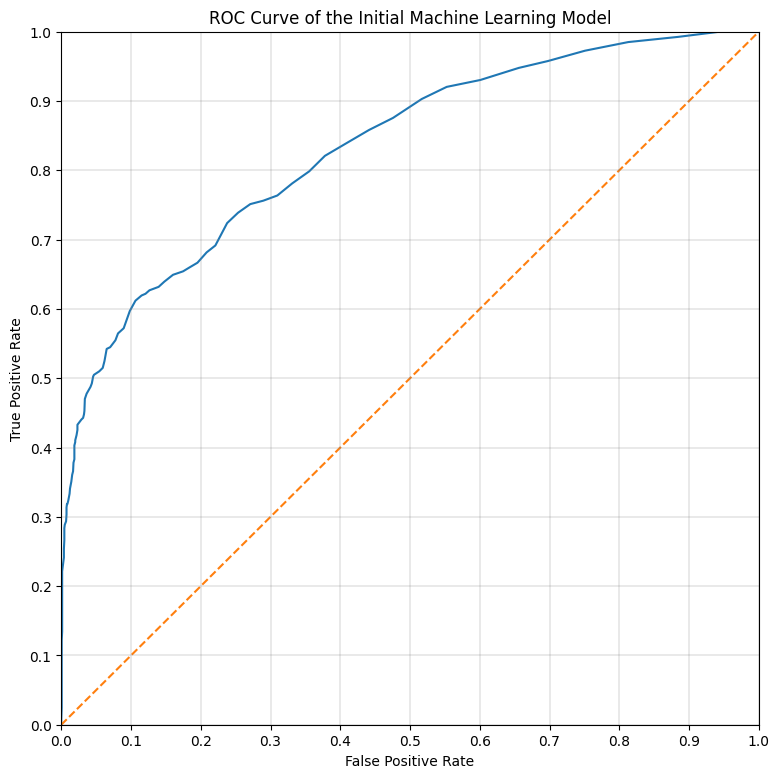


My initial model's AUC-ROC value is 0.8321058972969945


In [12]:
initial_probabilities_valid = initial_model.predict_proba(features_valid)
initial_probabilities_one_valid = initial_probabilities_valid[:, 1]
fpr_initial, tpr_initial, thresholds = roc_curve(target_valid, initial_probabilities_one_valid)

plt.figure(figsize = (9, 9))
plt.plot(fpr_initial, tpr_initial)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.title('ROC Curve of the Initial Machine Learning Model')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for xtick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axvline(x = xtick_value, color = 'grey', linestyle = '-', lw = 0.25)
    
for ytick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y = ytick_value, color = 'grey', linestyle = '-', lw = 0.25)

plt.show()

print()
auc_roc_initial_model = roc_auc_score(target_valid, initial_probabilities_one_valid)
print("My initial model's AUC-ROC value is", auc_roc_initial_model)

Just like with the precision, recall, and F1 score values, the closer the AUC-ROC value is to 1, the better. This is because if the AUC-ROC value was very close to 1, that would mean there exists at least one threshold where nearly every customer who stopped banking with Beta Bank is correctly identified as having left (true positives), AND nearly every customer who continues banking with Beta Bank is not incorrectly identified as having left (false positives).

To help me improve the model, I first need to figure out how much of an imbalance there is with the values of the target feature, **exited**.

In [13]:
display(client_data['exited'].value_counts())

exited
0    7963
1    2037
Name: count, dtype: int64

79.63% of the rows have an **exited** value of 0, and hence only 20.37% of the rows have an **exited** value of 1. This means that Beta Bank has about four times more data about customers who still bank with Beta Bank compared to data about customers who stopped banking with Beta Bank, an imbalance for sure!

# Section 3: Improving the Quality of the Model <a id=4></a>

**APPROACH #1 (Upsampling)** <a id=4.1></a>

I am curious to see if adding more rows with an **exited** value of 1 would improve the model. 

I will do this by upsampling, which is done by performing the following steps:

1) Splitting the training sample into positive and negative observations

2) Duplicating the positive observations several times

3) Creating a new training sample based on the data obtained

4) Shuffling the data

In [14]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 12345)

    return features_upsampled, target_upsampled

After defining the upsample function, I tried out setting **repeat** equal to 2, 3, and 4, and it was 3 that came closest to resulting in an F1 score of at least 0.59. 

Using trial and error, I found that 9 is a good value to set the max_depth parameter equal to. I then wanted to see if I could find a particular value for the n_estimators parameter that made the F1 score at least 0.595, and I found that n_estimators = 88 works! I used a for loop to find that n_estimators value, which is written in the code below.

Notice that the for loop is commented out. I did this on purpose because running the loop takes a long time.

In [15]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

upsampled_model = RandomForestClassifier(random_state = 12345, n_estimators = 88, max_depth = 9)

upsampled_model.fit(features_upsampled, target_upsampled)

upsampled_predicted_valid = upsampled_model.predict(features_valid)

#for n_est in range(1, 201):
#    upsampled_model = RandomForestClassifier(random_state = 12345, n_estimators = n_est, max_depth = 9)
#    upsampled_model.fit(features_upsampled, target_upsampled)
#    upsampled_predicted_valid = upsampled_model.predict(features_valid)
#    upsampled_model_f1 = f1_score(target_valid, upsampled_predicted_valid)
#    if upsampled_model_f1 >= 0.595:
#        print('n_estimators =', n_est, '; ', end = '')
#        print('F1 SCORE =', upsampled_model_f1)

In [16]:
precision_score_upsampled_model = precision_score(target_valid, upsampled_predicted_valid)
recall_score_upsampled_model = recall_score(target_valid, upsampled_predicted_valid)
f1_score_upsampled_model = f1_score(target_valid, upsampled_predicted_valid)

print("My upsampled model's PRECISION value is", precision_score_upsampled_model)
print()
print("My upsampled model's RECALL value is", recall_score_upsampled_model)
print()
print("My upsampled model's F1 SCORE is", f1_score_upsampled_model)

My upsampled model's PRECISION value is 0.6141732283464567

My upsampled model's RECALL value is 0.582089552238806

My upsampled model's F1 SCORE is 0.5977011494252874


Though my upsampled model's precision value is lower than that of my initial model, the recall value is higher, to the point that the F1 score is now about 0.5977, which is means I have successfully accomplished making a model with an F1 score of at least 0.59!

It's worth noting that my upsampled model has a higher portion of false positives than the initial model, but thankfully it has a lower portion of false negatives to compensate. Furthermore, the upsampled model has a precision value and a recall value that are similar to one another; in contrast, the initial model has a big gap between its precision value and its recall value.

Now let's plot the ROC curve of the upsampled model, and print the curve's AUC-ROC value.

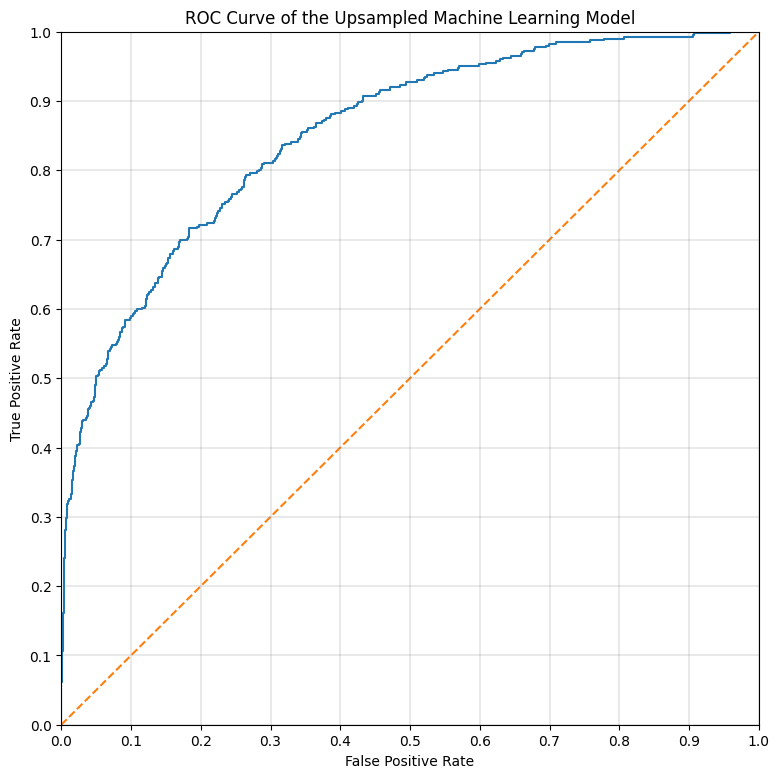


My upsampled model's AUC-ROC value is 0.8533147778006089


In [17]:
upsampled_probabilities_valid = upsampled_model.predict_proba(features_valid)
upsampled_probabilities_one_valid = upsampled_probabilities_valid[:, 1]
fpr_upsampled, tpr_upsampled, thresholds = roc_curve(target_valid, upsampled_probabilities_one_valid)

plt.figure(figsize = (9, 9))
plt.plot(fpr_upsampled, tpr_upsampled)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.title('ROC Curve of the Upsampled Machine Learning Model')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for xtick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axvline(x = xtick_value, color = 'grey', linestyle = '-', lw = 0.25)
    
for ytick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y = ytick_value, color = 'grey', linestyle = '-', lw = 0.25)

plt.show()

print()
auc_roc_upsampled_model = roc_auc_score(target_valid, upsampled_probabilities_one_valid)
print("My upsampled model's AUC-ROC value is", auc_roc_upsampled_model)

The initial model's AUC-ROC value is approximately 0.8321, whereas the upsampled model's AUC-ROC value is approximately 0.8533, an improvement!

**APPROACH #2 (Downsampling)** <a id=4.2></a>

Now let's try downsampling. I am curious to see if dropping some of the rows with an **exited** value of 0 would improve the model.

Downsampling is done by following these steps:

1) Splitting the training sample into positive and negative observations

2) Randomly dropping a portion of the negative observations

3) Creating a new training sample based on the data obtained

4) Shuffling the data

In [18]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac = fraction, random_state = 12345)] + [features_ones])
    
    target_downsampled = pd.concat([target_zeros.sample(frac = fraction, random_state = 12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = 12345)

    return features_downsampled, target_downsampled

After defining the downsample function, I tried out setting **fraction** equal to 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, and 0.9. Using 0.7 gave me the best F1 score.

Similar to what I did with the upsampling model, I wrote a for loop to see which **n_estimators** value would give me an F1 score that is even better than 0.6. Additionally, I once again used trial and error to find a good value for the **max_depth** parameter.

It turns out that setting **n_estimators** equal to 129 and **max_depth** equal to 27 results in an F1 score that is a little more than 0.605. Once again, I commented out the for loop on purpose.

In [19]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.7)

downsampled_model = RandomForestClassifier(random_state = 12345, n_estimators = 129, max_depth = 27)

downsampled_model.fit(features_downsampled, target_downsampled)

downsampled_predicted_valid = downsampled_model.predict(features_valid)

#for n_est in range(1, 201):
#    downsampled_model = RandomForestClassifier(random_state = 12345, n_estimators = n_est)
#    downsampled_model.fit(features_downsampled, target_downsampled)
#    downsampled_predicted_valid = downsampled_model.predict(features_valid)
#    downsampled_model_f1 = f1_score(target_valid, downsampled_predicted_valid)
#    if downsampled_model_f1 >= 0.6:
#        print('n_estimators =', n_est, '; ', end = '')
#        print('F1 SCORE =', downsampled_model_f1)

In [20]:
precision_score_downsampled_model = precision_score(target_valid, downsampled_predicted_valid)
recall_score_downsampled_model = recall_score(target_valid, downsampled_predicted_valid)
f1_score_downsampled_model = f1_score(target_valid, downsampled_predicted_valid)

print("My downsampled model's PRECISION value is", precision_score_downsampled_model)
print()
print("My downsampled model's RECALL value is", recall_score_downsampled_model)
print()
print("My downsampled model's F1 SCORE is", f1_score_downsampled_model)

My downsampled model's PRECISION value is 0.7256944444444444

My downsampled model's RECALL value is 0.5199004975124378

My downsampled model's F1 SCORE is 0.6057971014492753


This is a good result! The F1 score of my downsampled model is a little higher than that of my upsampled model. The downsampled model has a better precision value than the upsampled model, but this is largely offset by the worse recall value. This implies the downsampled model results in fewer false positives but more false negatives. Interestingly, the initial model has the best precision value but the worst recall value.

Furthermore, there is a rather large gap between the downsampled model's precision value and its recall value, unlike the upsampled model where its two values are very close to one another.

I will now plot the ROC curve of the downsampled model, and print the curve's AUC-ROC value.

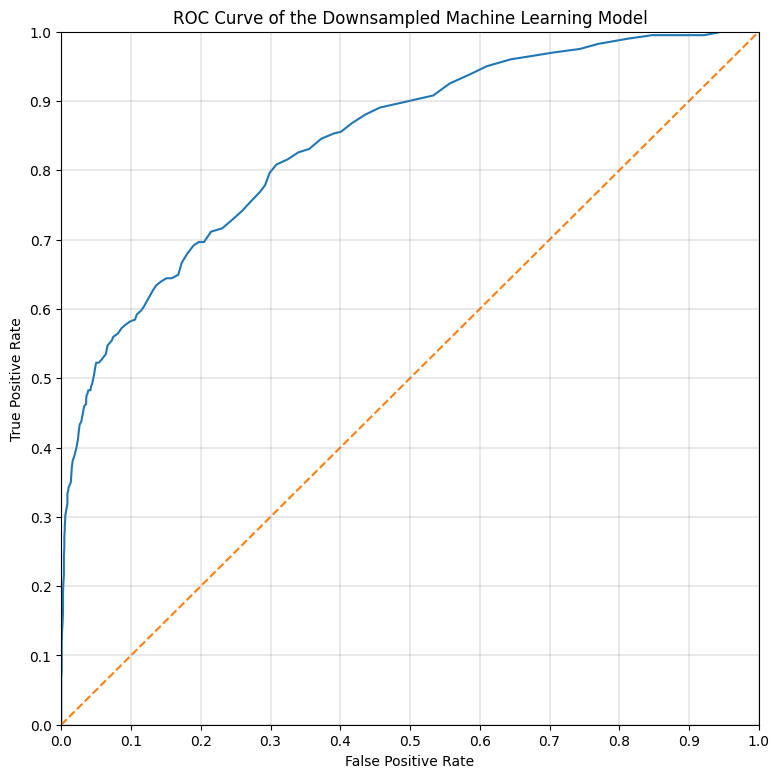


My downsampled model's AUC-ROC value is 0.8419448439903113


In [21]:
downsampled_probabilities_valid = downsampled_model.predict_proba(features_valid)
downsampled_probabilities_one_valid = downsampled_probabilities_valid[:, 1]
fpr_downsampled, tpr_downsampled, thresholds = roc_curve(target_valid, downsampled_probabilities_one_valid)

plt.figure(figsize = (9, 9))
plt.plot(fpr_downsampled, tpr_downsampled)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.title('ROC Curve of the Downsampled Machine Learning Model')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for xtick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axvline(x = xtick_value, color = 'grey', linestyle = '-', lw = 0.25)
    
for ytick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y = ytick_value, color = 'grey', linestyle = '-', lw = 0.25)

plt.show()

print()
auc_roc_downsampled_model = roc_auc_score(target_valid, downsampled_probabilities_one_valid)
print("My downsampled model's AUC-ROC value is", auc_roc_downsampled_model)

Interesting... the downsampled model's AUC-ROC value is greater than the initial model, but lower than the upsampled model.

# Section 4: Performing the Final Test <a id=5></a>

It is difficult to decide whether to perform the final test on the upsampled model or the downsampled model because they have such similar F1 scores and AUC-ROC values. That said, I think it makes more sense to choose the upsampled model since there is such a small gap between the resulting precision value and the resulting recall value. (If I chose the downsampled model, then the low recall value might prevent the F1 score from being at least 0.59.)

In [22]:
upsampled_final_test = upsampled_model.predict(features_test)

precision_score_final_test = precision_score(target_test, upsampled_final_test)
recall_score_final_test = recall_score(target_test, upsampled_final_test)
f1_score_final_test = f1_score(target_test, upsampled_final_test)

print("The PRECISION value of the final test is", precision_score_final_test)
print()
print("The RECALL value of the final test is", recall_score_final_test)
print()
print("The F1 SCORE of the final test is", f1_score_final_test)

The PRECISION value of the final test is 0.6241299303944315

The RECALL value of the final test is 0.629976580796253

The F1 SCORE of the final test is 0.627039627039627


Great! The F1 score of the final test is still at least 0.59, as it should be! Furthermore, as expected, the precision value is very similar to the recall value.

What is the AUC-ROC value?

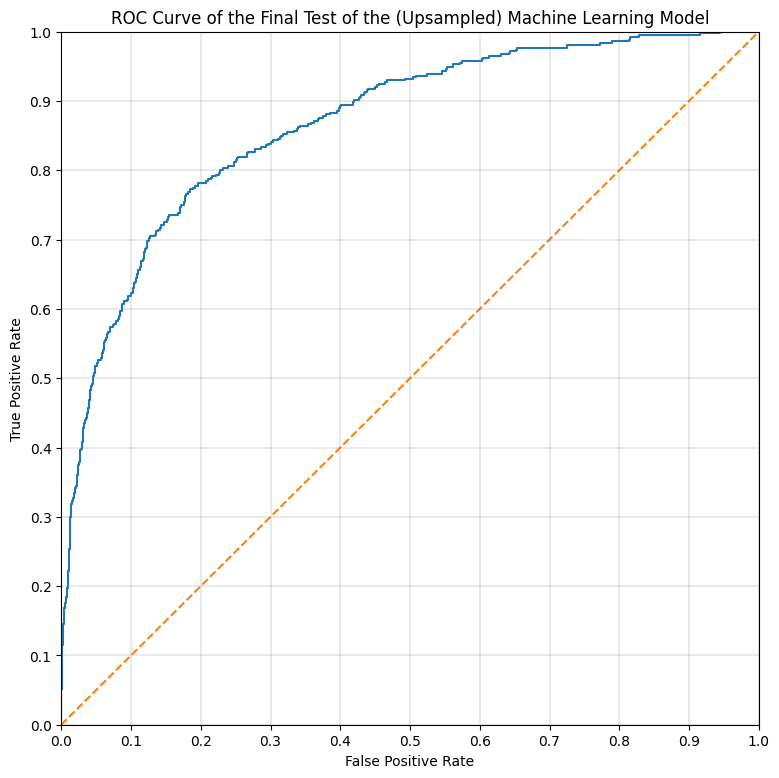


My final test's AUC-ROC value is 0.866592423969473


In [23]:
upsampled_probabilities_final_test = upsampled_model.predict_proba(features_test)
upsampled_probabilities_one_final_test = upsampled_probabilities_final_test[:, 1]
fpr_final_test, tpr_final_test, thresholds = roc_curve(target_test, upsampled_probabilities_one_final_test)

plt.figure(figsize = (9, 9))
plt.plot(fpr_final_test, tpr_final_test)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.title('ROC Curve of the Final Test of the (Upsampled) Machine Learning Model')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for xtick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axvline(x = xtick_value, color = 'grey', linestyle = '-', lw = 0.25)
    
for ytick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y = ytick_value, color = 'grey', linestyle = '-', lw = 0.25)

plt.show()

print()
auc_roc_final_test = roc_auc_score(target_test, upsampled_probabilities_one_final_test)
print("My final test's AUC-ROC value is", auc_roc_final_test)

Fantastic! This is actually the highest AUC-ROC value I have acquired this whole project! The final test is a success!

One thing I haven't mention yet is that the ROC curve is a convenient way to give a machine learning model a sanity check. 

Hypothetically, if the AUC-ROC value was exactly 0.5, that would mean the model is no better at classifying outcomes than random chance. Furthermore, if the AUC-ROC value was less than 0.5, that would mean the model is even worse at classifying than random chance. Since I got an AUC-ROC value that is much closer to 1 than it is to 0.5, I may be confident that my model is much better at classifying than random chance.

# Conclusion <a id=6></a>

I am happy to inform Beta Bank stakeholders that I have a successfully built a random forest machine learning model that uses data on clients’ past behavior and termination of contracts with the bank to predict whether or not a customer is likely to leave the bank soon. 

I was able to acquire the model by first realizing that there was a huge imbalance in the values of the target feature, **exited**, then experimenting with upsampling and downsampling. 

Ultimately, I decided that the upsampled model is the better of the two. My testing demonstrates that the model yields an F1 score of at least 0.59 and an AUC-ROC value of at least 0.85, meaning this model is ***much*** more accurate at classifying customers, between those who will (most likely) leave Beta Bank and those who will (most likely) stay, than random chance.

Lastly, I think it is worth mentioning how promising the thresholds on the ROC curves are. My testing has demonstrated that the model's ROC curves have a point located at approximately (0.3, 0.8), which means that about 30% of customers who have not left Beta Bank were mistakingly classified as having left (false positives), and about 80% of customers who did leave Beta Bank were correctly classified as having left (true positives). 

If Beta Bank stakeholders happen to conclude that 80% is not a high enough percentage for the true positives, and they don't mind increasing the rate of false positives if it means increasing the rate of true positives, then another approximate point on the ROC curve is (0.45, 0.9). 